# Online Training
Simulating a complex phenomenon can be computationally intensive and expensive. In some cases
the computational model is too expensive or too slow to be used in production, for example, when
results are needed in real time. In other cases, a correct computational model, capable of
predicting the behavior of a complex system, might not even exist, see e.g. [this article](https://arxiv.org/abs/2104.09355).
*Surrogate models*, or simply *surrogates*, can compute the outcome of a given experiment
up to a reasonable degree of approximation, while requiring little computational power or time.

In this notebook, a neural network is trained to act like a surrogate model and to solve a
well-known physical problem, i.e. computing the steady state of heat diffusion. The training
dataset is constructed by running simualations *while* the model is being trained.

## 2D Heat Diffusion and Steady State
Throughout this notebook, the heat equation will be solved on the two-dimensional domain $[0,1]\times[0,1]$, setting the initial temperature to 0 K, except
for some specific spots (of radius $0.05$), where heat sources at a constant temperature of 1 K are placed. Since
all boundaries are kept at 0 K, after enough time, the domain will reach a steady state, which is the outcome
the surrogate model will learn to compute.

The problem can be solved using a finite difference scheme. To this end, a modified version of the code
written by John Burkardt will be used. Its original version is licensed under LGPL, and so is this example.
The code was downloaded from [this page](https://github.com/johannesgerer/jburkardt-m/tree/master/fd2d_heat_steady),
which explains how the problem is discretized and solved.

In the modified version of the code which will be used, a random number (between 1 and 5) of heat sources is placed.
Here below, the solver is run with different initial conditions and the results are displayed.
To keep the solution time reasonably short, the domain is discretized with a 64x64-point grid.

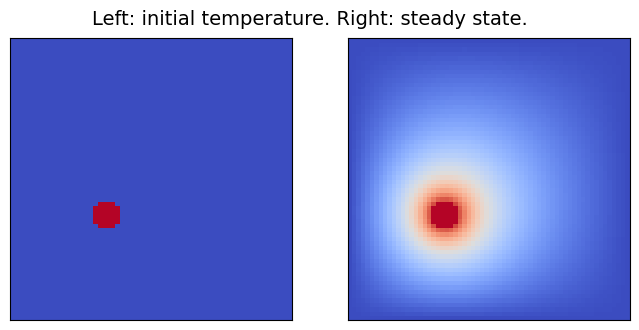

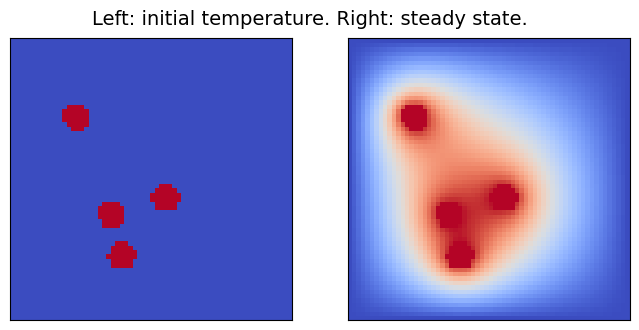

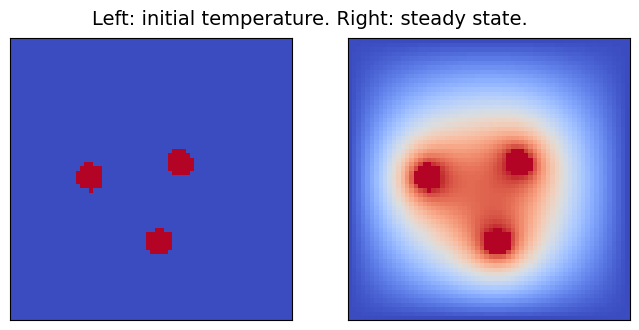

In [8]:
%matplotlib inline

from steady_state import fd2d_heat_steady_test01
from vishelpers import pcolor_list
import time
from numpy.random import default_rng


size = 64

for _ in range(3):
    u_s = fd2d_heat_steady_test01 (size, size)
    pcolor_list(u_s, "Left: initial temperature. Right: steady state.")


# The Surrogate Model

The surrogate model will be a Convolutional Neural Network (CNN). The 
training set will be constructed on the fly, by running
multiple simulations.

## Model Topology

The initial design for the Convolutional Neural Network (CNN) used in this notebook was inspired by the NN2 model
defined in [this paper](https://arxiv.org/abs/2102.05527). 
Half of the Neural Network (NN) computes an encoding of the initial image: each
convolutional layer downsamples the image by a factor 4, and doubles the
number of channels (the input has one single channel). The second
half of the NN reverses the operations, by upscaling the image
by a factor 4 at each layer and halving the number of channels.
In this variation of the model, residual blocks are used instead
of convolutional layers, and skip connection between
layers which are "symmetric" with respect to the center of the NN are added
(the output of the 1st layer is added to the input of the $n-1$-th layer, the 
ouput of the 2nd layer is added to the input of the $n-2$-th layer, and so on).

The model is defined in the file `tf_model.py`, and its depth is parametrized:
for a $64 \times 64$ domain, the maximum depth is $6$, but with a depth of $3$ or $4$
the results are already noteworthy (and require less resources).

## Integrating SmartRedis and SmartSim in the Simulation

As in the Lattice Boltzmann tutorial, we use SmartRedis to stage tensors.

For each simulation, both the initial conditions and the steady state solution are put
on the database (DB). Since the data will be used to train a Neural Network, 
an object of the type `TrainingDataUploader` is used in the code. It \puts the data
on the DB in batches which will be consumed by the training process.
The function `simulate` contained in `fd_sim.py`
is the core of the computation. Notice that samples are augmented
before being uploaded as batches: for each simulation,
eight rotated and reflected version of the original samples are 
uploaded.

```python
def simulate(steps, size):
    """Run multiple simulations and upload results
    
    both as tensors and as augmented samples for training.

    :param steps: Number of simulations to run
    :type steps: int
    :param size: lateral size of the discretized domain
    :type size: int
    """
    batch_size = 50
    samples = np.zeros((batch_size,size,size,1)).astype(np.single)
    targets = np.zeros_like(samples).astype(np.single)
    client = Client(None, False)

    training_data_uploader = TrainingDataUploader(cluster=False, verbose=True)
    training_data_uploader.publish_info()

    for i in tqdm(range(steps)):
        
        u_init, u_steady = fd2d_heat_steady_test01(samples.shape[1], samples.shape[2])
        u_init = u_init.astype(np.single)
        u_steady = u_steady.astype(np.single)
        dataset = create_dataset(i, u_init, u_steady)
        client.put_dataset(dataset)

        samples[i%batch_size, :, :, 0] = u_init
        targets[i%batch_size, :, :, 0] = u_steady

        if (i+1)%batch_size == 0:
            augmented_samples, augmented_targets = augment_batch(samples, targets)
            training_data_uploader.put_batch(augmented_samples, augmented_targets)

```


## Starting the Experiment

SmartSim, the infrastructure library, is used here to launch the
database, the simulation, and the NN training locally, but in separate processes.
The example is designed to run on laptops, so the local launcher is used.

First, the necessary libraries are imported, and an `Experiment` instance is created.
An `Orchestrator` database reference is initialized and launched 
to stage data between the simulation, the NN training, and this notebook where results
will be analyzed.

In [9]:
from smartredis import Client
from smartsim import Experiment
# Initialize an Experiment with the local launcher
# This will be the name of the output directory that holds
# the output from our simulation and SmartSim
exp = Experiment("surrogate_training", launcher="local")


In [10]:
# create an Orchestrator database reference,
# generate its output directory, and launch it locally
db = exp.create_database(port=6780, interface="lo")
exp.generate(db, overwrite=True)
exp.start(db)
print(f"Database started at address: {db.get_address()}")


Database started at address: ['127.0.0.1:6780']


## Running an Ensemble of Simulations

To run the simulation, `Experiment.create_run_settings` is used to define how the
simulation should be executed. To obtain a larger number of samples, we run
an ensemble of simulations, i.e. multiple replicas of the simulation,
each one producing different samples. To set up the ensemble, the settings 
are then passed to create a reference to the ensemble through a call
to `Experiment.create_ensemble()` which
can be used to start, monitor, and stop the simulations from this notebook. 
Notice the call to `enable_key_prefixing()`: that will make sure
each simulation adds a prefix to the keys it uploads, to avoid
key clashes with other ensemble members.

In [11]:
# set simulation parameters we can pass as executable arguments
# Number of simulations to run in each replica
steps = 100

# create "run settings" for the simulation which define how
# the simulation will be executed when passed to Experiment.start()
settings = exp.create_run_settings("python",
                                   exe_args=["fd_sim.py",
                                             f"--steps={steps}",
                                             f"--size={size}"],
                                   env_vars={"OMP_NUM_THREADS": "8"})

# Create the ensemble reference to our simulation and
# attach needed files to be copied, configured, or symlinked into
# the ensemble directories at runtime.
ensemble = exp.create_ensemble("fd_simulation", run_settings=settings, replicas=2)
ensemble.attach_generator_files(to_copy=["fd_sim.py", "steady_state.py"])
ensemble.enable_key_prefixing()
exp.generate(ensemble, overwrite=True)


## Using SmartSim to Train the Neural Network

The last component of the workflow is the model training.
For this notebook, the neural network will be trained
using TensorFlow and Keras, but PyTorch is supported too,
and a corresponding notebook will soon be available.

In the code, an object of the type `smartsim.ml.tf.DynamicDataGenerator`
is passed to Keras's `Model.fit()` function. The data generator
will download batches from the database before the training starts
and then, after each epoch, it will poll the database to
check whether new batches are available for download.

The core of the training code is in `tf_training.py`:

```python
def train_model(model, epochs):
    training_generator = DynamicDataGenerator(cluster=False, verbose=True, batch_size=25, shuffle=True)
    print("Compiling NN")

    initial_learning_rate = 0.01
    lr_schedule = keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate,
        decay_steps=80,
        decay_rate=0.9,
        staircase=True)

    optimizer = keras.optimizers.Adam(learning_rate=lr_schedule,
                                        beta_1=0.9,
                                        beta_2=0.999,
                                        epsilon=1e-07)

    model.compile(optimizer=optimizer, loss="mean_absolute_error")

    for epoch in range(epochs):
        print(f"Epoch {epoch+1}")
        model.fit(training_generator, steps_per_epoch=None, 
                  epochs=epoch+1, initial_epoch=epoch, batch_size=training_generator.batch_size,
                  verbose=2)
        if (epoch+1)%10 == 0:
            store_model(model, epoch//10)
```

Notice that after each 10 epochs, a copy of the current state of the model
is uploaded to the database. It will be used in this notebook to
look at the evolution of the model prediction.

To set up the model, run settings are defined with the parameters
chosen for this run, and used in `Experiment.create_model()`.
To allow the training process to check for data produced by the
ensemble members, they must be registered as incoming entities
by calling `Model.register_incoming_entity()`.

In [12]:
nn_depth = 4
epochs = 40

ml_settings = exp.create_run_settings("python",
                                   exe_args=["tf_training.py",
                                             f"--depth={nn_depth}",
                                             f"--epochs={epochs}",
                                             f"--size={size}"],
                                   env_vars={"OMP_NUM_THREADS": "16"})

ml_model = exp.create_model("tf_training", ml_settings)
ml_model.attach_generator_files(to_copy=["tf_training.py", "tf_model.py"])
for sim in ensemble.entities:
    ml_model.register_incoming_entity(sim)
exp.generate(ml_model, overwrite=True)


Once the ensemble and the model are defined, they are started by passing the references
to `Experiment.start()`.
The workflow is started with the `block=False` argument. This runs the ensemble
and the training in a nonblocking manner so that the data being streamed
from the simulation, and the training process can be
analyzed in real time.

In [13]:
exp.start(ensemble, ml_model, block=False, summary=False)


## Progress Visualization

To monitor the progress made by the training process,
the intermediate models are run on samples drawn randomly
from the `Orchestrator` database as soon as they are available.

Notice that the inference happens on the database
through a call to `Client.run_model()`, and only
the result is downloaded to be displayed.

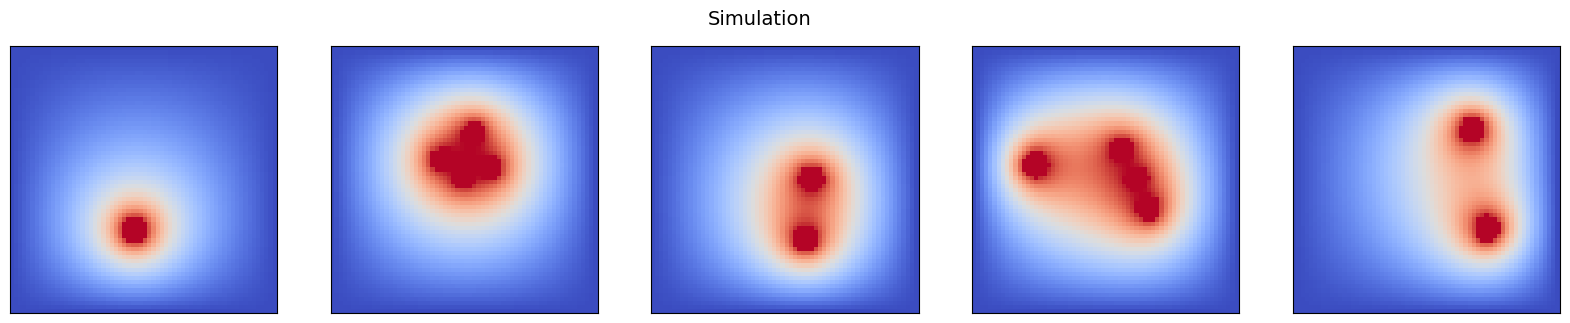

Default@20-19-36:ERROR: Redis IO error when executing command: Failed to get reply: Resource temporarily unavailable
Default@20-19-37:ERROR: Redis IO error when executing command: Failed to get reply: Resource temporarily unavailable


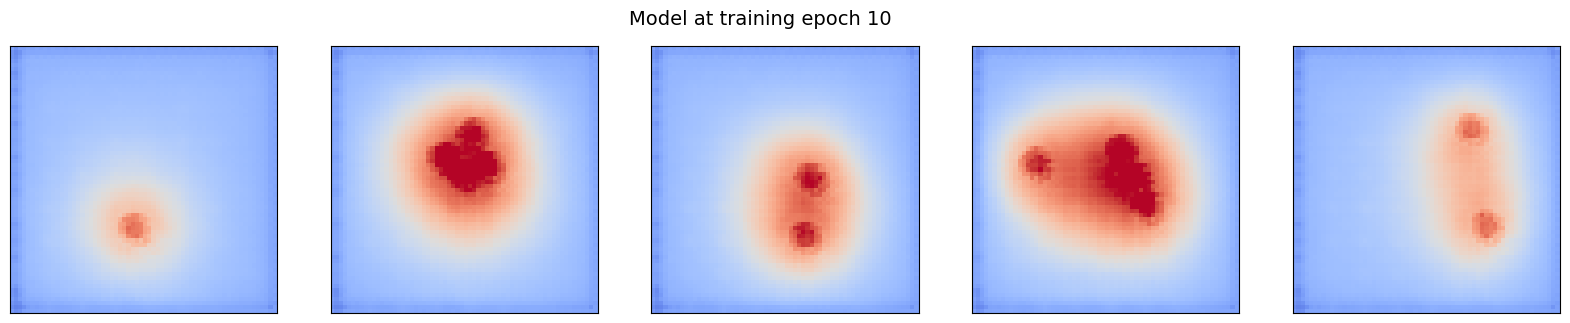

20:20:52 HPE-C02YR4ANLVCJ SmartSim[15001:JobManager] INFO fd_simulation_0(18881): SmartSimStatus.STATUS_COMPLETED
20:22:06 HPE-C02YR4ANLVCJ SmartSim[15001:JobManager] INFO fd_simulation_1(18882): SmartSimStatus.STATUS_COMPLETED
20:23:28 HPE-C02YR4ANLVCJ SmartSim[15001:JobManager] INFO tf_training(18887): SmartSimStatus.STATUS_COMPLETED


Default@20-20-52:ERROR: Redis IO error when executing command: Failed to get reply: Resource temporarily unavailable


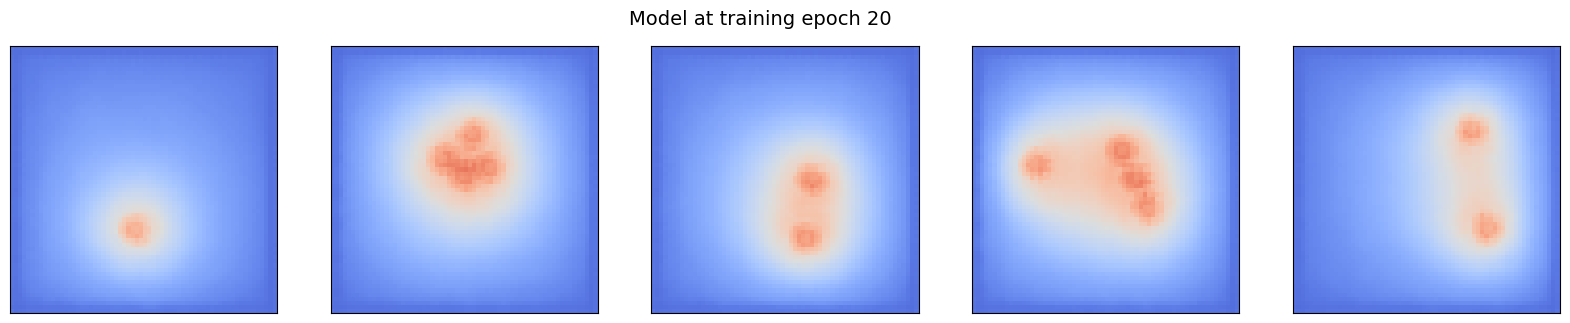

Default@20-22-07:ERROR: Redis IO error when executing command: Failed to get reply: Resource temporarily unavailable


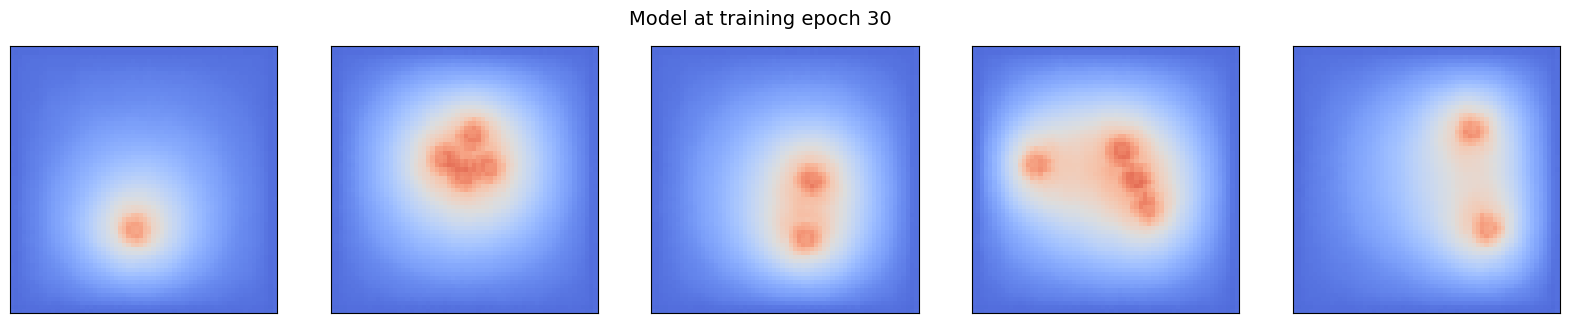

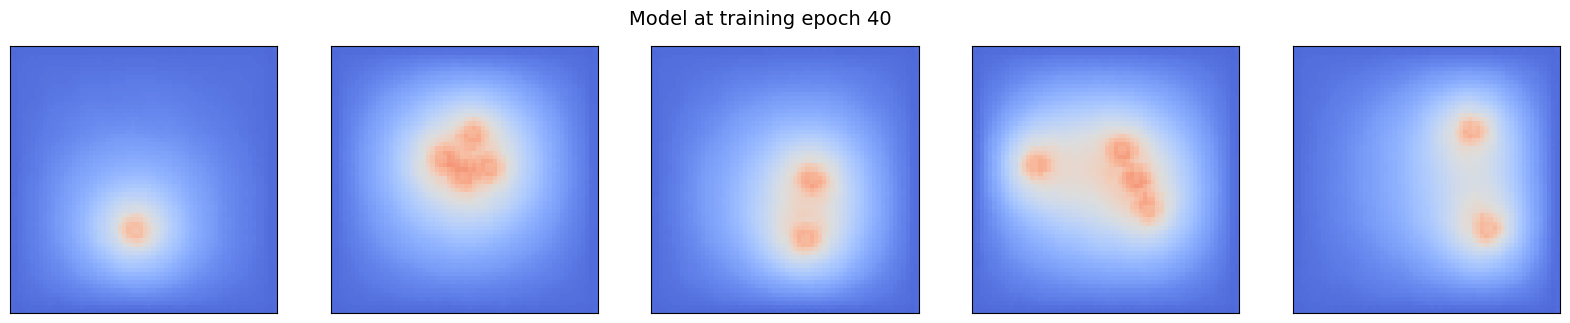

In [14]:
# Connect a SmartRedis client to retrieve data while the
# simulation is producing it and storing it within the
# orchestrator database

client = Client(address=db.get_address()[0], cluster=False)

num_tests = 5
rng = default_rng()
# Choose some random samples from the simulation
sample_indices = rng.choice(steps//5, size=num_tests, replace=False)
sample_indices.sort()

samples = []
for sample_idx in sample_indices:
    u_steady_name = ensemble.entities[0].name + ".{sim_data_" + str(sample_idx)+ "}.u_steady"
    client.poll_key(u_steady_name, 300, 1000)
    samples.append(client.get_tensor(u_steady_name).squeeze())

pcolor_list(samples, "Simulation")

for i in range(0, epochs//10):
    nn_name = f"DiffusionResNet_{nn_depth}_{i}"
    client.poll_key(nn_name, 300, 1000)
    ml_steady = []
    for sample_idx in sample_indices:
        u_init_name = ensemble.entities[0].name + ".{sim_data_" + str(sample_idx)+ "}.u_init"
        client.run_model(nn_name, inputs=[u_init_name], outputs=[f"ml_steady_{sample_idx}"])
        ml_steady.append(client.get_tensor(f"ml_steady_{sample_idx}").squeeze())

    pcolor_list(ml_steady, f"Model at training epoch {(i+1)*10}")


In [15]:
# Optionally clear the database
client.flush_db(db.get_address())


In [16]:
# Use the Experiment API to wait until the model
# is finished and then terminate the database and
# release it's resources
while not all([exp.finished(ensemble), exp.finished(ml_model)]):
    time.sleep(5)

exp.stop(db)


In [17]:
exp.get_status(ensemble, ml_model)


[<SmartSimStatus.STATUS_COMPLETED: 'Completed'>,
 <SmartSimStatus.STATUS_COMPLETED: 'Completed'>,
 <SmartSimStatus.STATUS_COMPLETED: 'Completed'>]

In [18]:
exp.summary(style="html")


,Name,Entity-Type,JobID,RunID,Time,Status,Returncode
0,fd_simulation_0,Model,18881,0,309.6291,SmartSimStatus.STATUS_COMPLETED,0
1,fd_simulation_1,Model,18882,0,384.0497,SmartSimStatus.STATUS_COMPLETED,0
2,tf_training,Model,18887,0,464.0114,SmartSimStatus.STATUS_COMPLETED,0
3,orchestrator_0,DBNode,18822,0,476.6033,SmartSimStatus.STATUS_CANCELLED,0
